In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import time

In [2]:
# Set random seed untuk reproduktibilitas
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# 1. Memuat dan Memproses Data
data_df = pd.read_excel('residual_arima.xlsx')
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d/%m/%Y')
data_df.set_index('Date', inplace=True)
residuals = data_df['Residual'].values.astype(float)

In [4]:
def split_and_scale(residuals):
    # split train, val, test
    train_val, test = train_test_split(residuals, test_size=0.3, shuffle=False)
    train, val = train_test_split(train_val, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train.reshape(-1, 1)).flatten()
    val_scaled = scaler.transform(val.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

    return train_scaled, val_scaled, test_scaled, scaler

In [5]:
train_data, val_data, test_data, scaler = split_and_scale(residuals)

SEQ_LEN = 28

def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len - 1):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

X_train, y_train = create_sequences(train_data, SEQ_LEN)
X_val, y_val = create_sequences(val_data, SEQ_LEN)
X_test, y_test = create_sequences(test_data, SEQ_LEN)

print("\nShape Data:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")



Shape Data:
X_train: (205, 28), y_train: (205,)
X_val: (30, 28), y_val: (30,)
X_test: (97, 28), y_test: (97,)


In [6]:
# 5. Convert to torch tensors, DataLoader
X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(-1)  # (batch, seq, 1)
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(-1)
y_test_tensor = torch.from_numpy(y_test).float()

BATCH_SIZE = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [7]:
# 6. Positional Encoding untuk Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [8]:
# 7. Transformer model untuk time series forecasting
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, d_model=64, nhead=4, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_linear = nn.Linear(feature_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        # src: (batch, seq_len, feature_size)
        src = self.input_linear(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, -1, :]  # ambil output step terakhir
        out = self.decoder(output)
        return out.squeeze(-1)

In [9]:
# 8. Inisialisasi model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeSeriesTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
# 9. Training loop
EPOCHS = 300
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Eval
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            loss = criterion(output, yb)
            test_loss += loss.item() * xb.size(0)
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/300, Train Loss: 0.6591, Test Loss: 0.3637
Epoch 5/300, Train Loss: 0.1389, Test Loss: 0.1011
Epoch 10/300, Train Loss: 0.0664, Test Loss: 0.1302
Epoch 15/300, Train Loss: 0.0552, Test Loss: 0.0793
Epoch 20/300, Train Loss: 0.0524, Test Loss: 0.0730
Epoch 25/300, Train Loss: 0.0557, Test Loss: 0.0749
Epoch 30/300, Train Loss: 0.0370, Test Loss: 0.0915
Epoch 35/300, Train Loss: 0.0393, Test Loss: 0.0736
Epoch 40/300, Train Loss: 0.0369, Test Loss: 0.0810
Epoch 45/300, Train Loss: 0.0401, Test Loss: 0.0840
Epoch 50/300, Train Loss: 0.0423, Test Loss: 0.0882
Epoch 55/300, Train Loss: 0.0356, Test Loss: 0.1008
Epoch 60/300, Train Loss: 0.0307, Test Loss: 0.1179
Epoch 65/300, Train Loss: 0.0368, Test Loss: 0.0737
Epoch 70/300, Train Loss: 0.0323, Test Loss: 0.0894
Epoch 75/300, Train Loss: 0.0306, Test Loss: 0.1127
Epoch 80/300, Train Loss: 0.0302, Test Loss: 0.0970
Epoch 85/300, Train Loss: 0.0283, Test Loss: 0.1282
Epoch 90/300, Train Loss: 0.0276, Test Loss: 0.0939
Epoch 95/300, 

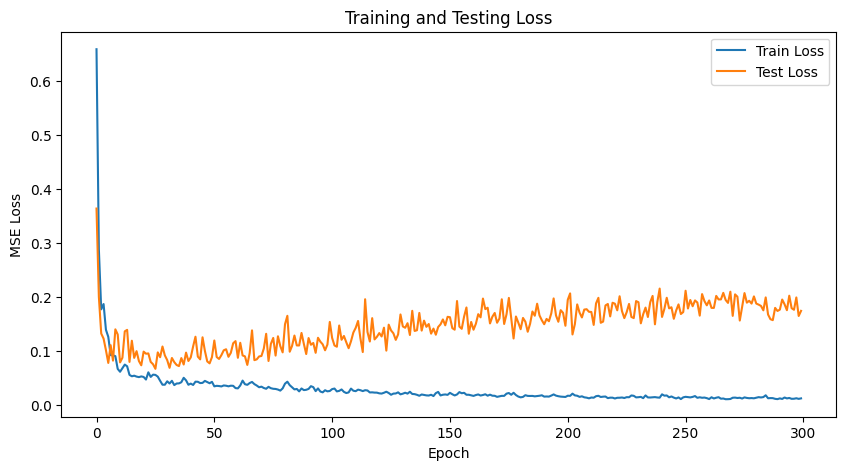

In [11]:
# 10. Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Testing Loss')
plt.show()

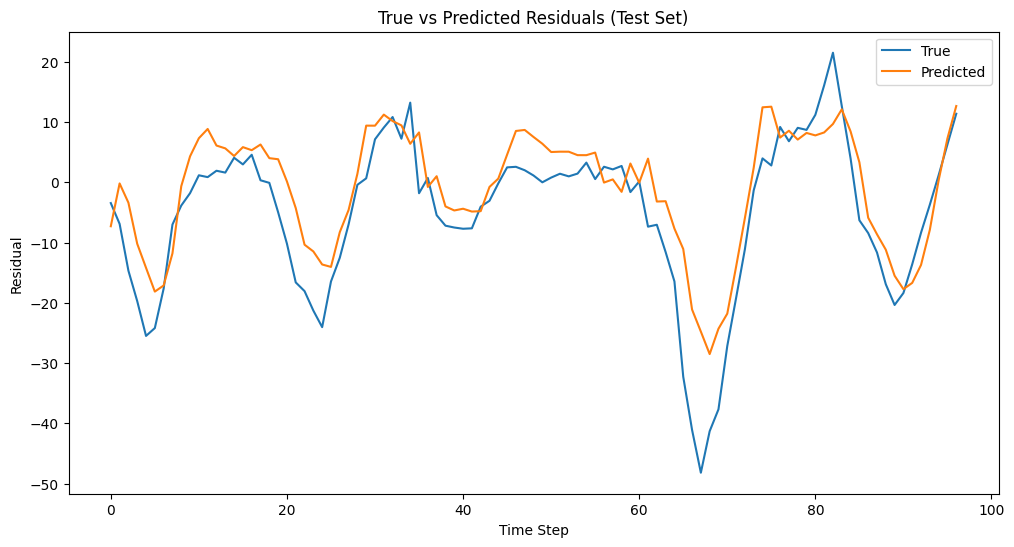

In [12]:
# 11. Prediction & Plot
model.eval()
with torch.no_grad():
    preds = []
    for xb, _ in test_loader:
        xb = xb.to(device)
        pred = model(xb)
        preds.append(pred.cpu().numpy())
    preds = np.concatenate(preds)

# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()

plt.figure(figsize=(12,6))
plt.plot(range(len(y_test_inv)), y_test_inv, label='True')
plt.plot(range(len(preds_inv)), preds_inv, label='Predicted')
plt.legend()
plt.title('True vs Predicted Residuals (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Residual')
plt.show()

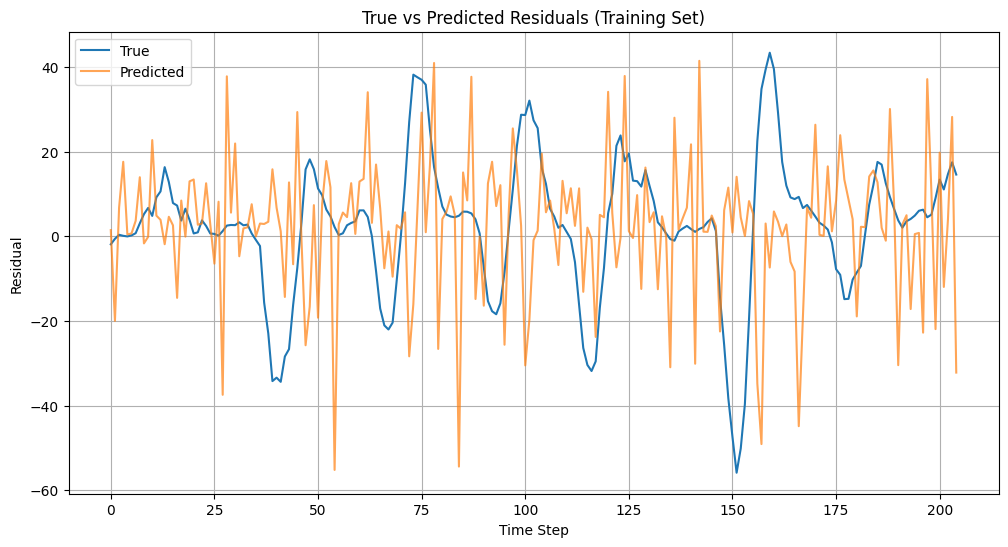

In [13]:
# 12. Prediction & Plot (TRAIN VERSION)
model.eval()
with torch.no_grad():
    train_preds = []
    for xb, _ in train_loader:  # Ganti test_loader -> train_loader
        xb = xb.to(device)
        pred = model(xb)
        train_preds.append(pred.cpu().numpy())
    train_preds = np.concatenate(train_preds)

# Inverse scaling
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
train_preds_inv = scaler.inverse_transform(train_preds.reshape(-1, 1)).flatten()

# Plot
plt.figure(figsize=(12,6))
plt.plot(range(len(y_train_inv)), y_train_inv, label='True')
plt.plot(range(len(train_preds_inv)), train_preds_inv, label='Predicted', alpha=0.7)
plt.legend()
plt.title('True vs Predicted Residuals (Training Set)')
plt.xlabel('Time Step')
plt.ylabel('Residual')
plt.grid(True)
plt.show()


In [14]:
# 12. Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("Test MSE:", mean_squared_error(y_test_inv, preds_inv))
print("Test MAE:", mean_absolute_error(y_test_inv, preds_inv))
print("Test R2:", r2_score(y_test_inv, preds_inv))

print("\nTraining Metrics:")
print("Train MSE:", mean_squared_error(y_train_inv, train_preds_inv))
print("Train MAE:", mean_absolute_error(y_train_inv, train_preds_inv))
print("Train R2:", r2_score(y_train_inv, train_preds_inv))

Test MSE: 48.7456996181141
Test MAE: 5.419695463964888
Test R2: 0.7012930179181887

Training Metrics:
Train MSE: 566.1689418087583
Train MAE: 17.409471182798562
Train R2: -1.1592243383517409
